In [1]:
#importing req. Lib.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pprint import pprint
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import nltk
import pickle
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as plt_gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read in the datafile
data = pd.read_csv('Tweets.csv')

In [3]:
#Number of rows and columns
data.shape

(14640, 15)

In [4]:
#Looking into our data
data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [5]:
#Checking columns in our data
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

### Worldcloud

Text(0.5, 1.0, 'Count of Type of Sentiment')

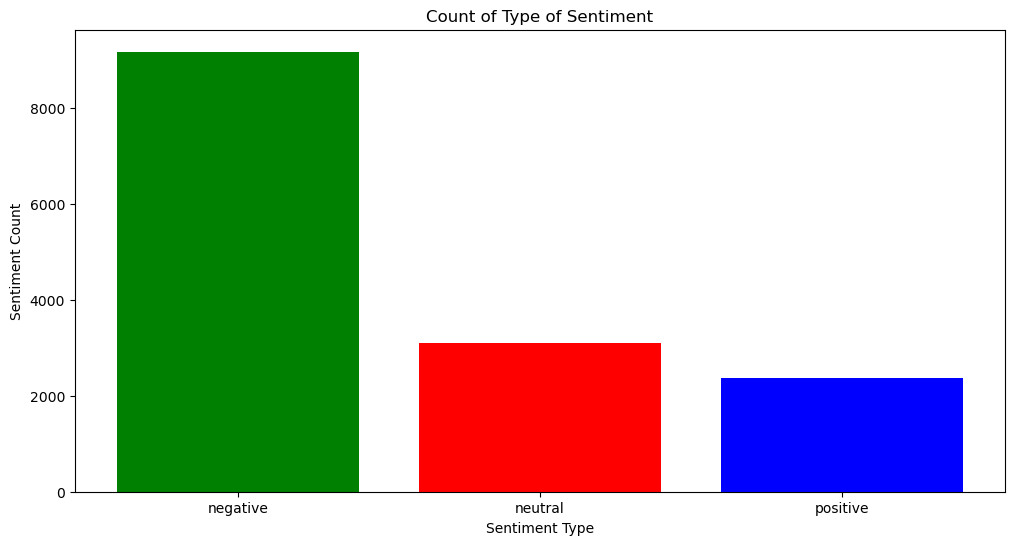

In [6]:
#Plot the overall distribution of sentiments for all the airline
counter = data.airline_sentiment.value_counts()
index = [1,2,3]
plt.figure(1,figsize=(12,6))
plt.bar(index,counter,color=['green','red','blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=0)
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')

In [7]:
#One immediate observation from the data is that, JetBlue airline tweets are missclassified as 'Delta' in the dataset
data[data['airline'] == 'Delta']['text'].head(10).values[5]

'@JetBlue update on Flight 462 would be appreciated when you have time, thanks'

In [8]:
# clean the hashtags, mentions, punctuations, urls, etc
def clean_tweet(tweet):
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = " ".join(word for word in temp)
    return temp


In [9]:
# Not used this for the wordclud since it was giving some root words which did not make any sense. Can try this using the specified columns

lemmatizer = WordNetLemmatizer()
def stem_tweet(text):
    words = nltk.word_tokenize(text)
    text = " ".join([lemmatizer.lemmatize(word) for word in words])
    return text

data['text_wc_u'] = data['text'].apply(clean_tweet)
data['text_wc_u'] = data['text_wc_u'].apply(stem_tweet)

In [10]:
#Applying the cleaning steps to the tweets
data['text_wc'] = data['text'].apply(clean_tweet)

In [11]:
# Definition to create wordcloud for different airlines

def word_cloud(data,stopwords):
    # Create subplots for each sentiment
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
    axs = axs.flatten()

    #These set of worlclouds are on the preprocessed tweets
    for i, airline in enumerate(data['airline'].unique()):
        text = ' '.join(data.loc[data['airline'] == airline, 'text'])
        wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(text)

        # Plot the wordcloud in the corresponding subplot
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].set_title(airline)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
# Create a set of stopwords
stopwords = set(stopwords.words('english'))
stopwords.update(["thank", "thanks",'flight','flights',"now"])

#### Wordcloud for Pre-processed tweets

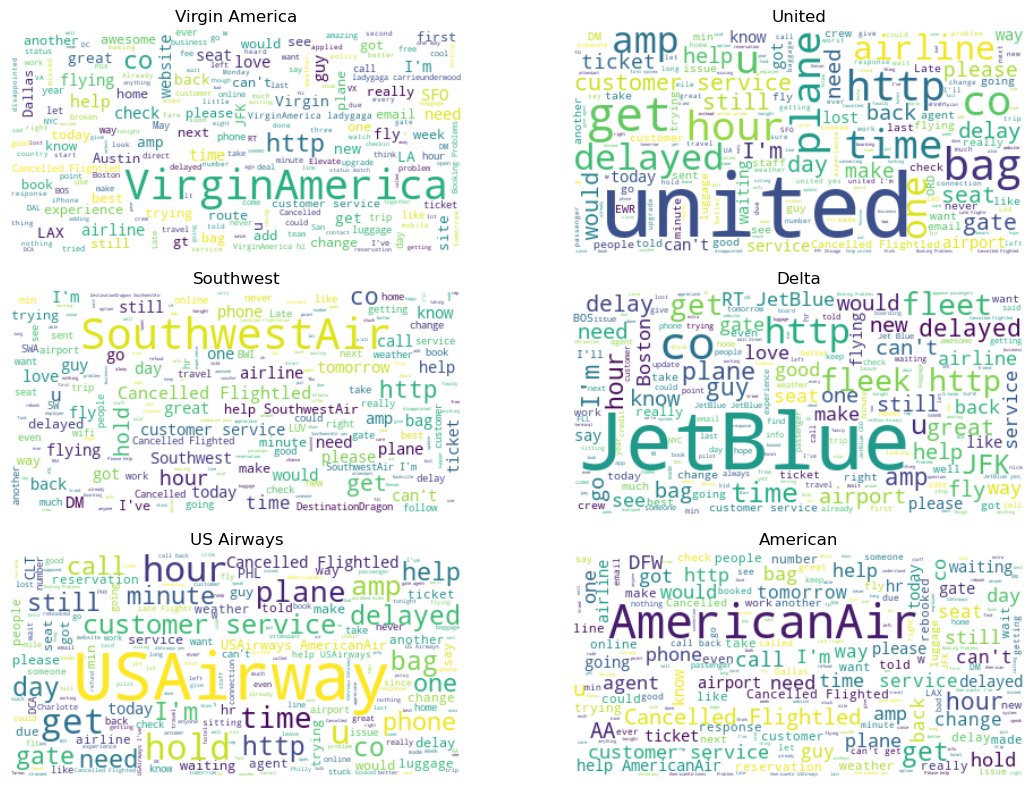

In [13]:
pre_data = data[['airline', 'text']].copy() 

word_cloud(pre_data,stopwords)

#### Worcloud after processing the tweets

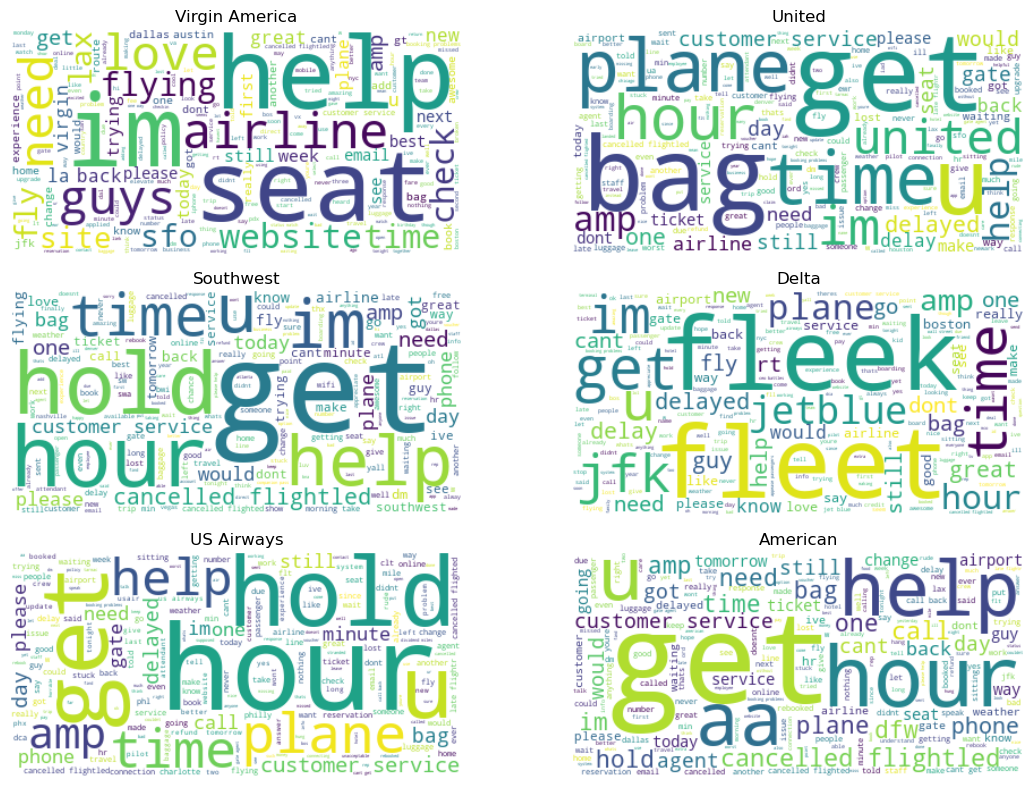

In [14]:
post_data = data[['airline', 'text_wc']].copy() 
post_data.loc[:, 'text'] = post_data['text_wc'] 

word_cloud(post_data,stopwords)

### Wordclouds to understand if there is any difference between the positive and negative tweets

In [17]:
post_data = data[['airline_sentiment','airline', 'text_wc']].copy() 
post_data.loc[:, 'text'] = post_data['text_wc'] 

data1 = post_data[post_data['airline_sentiment'] == 'negative']
data2 = post_data[post_data['airline_sentiment'] == 'positive']

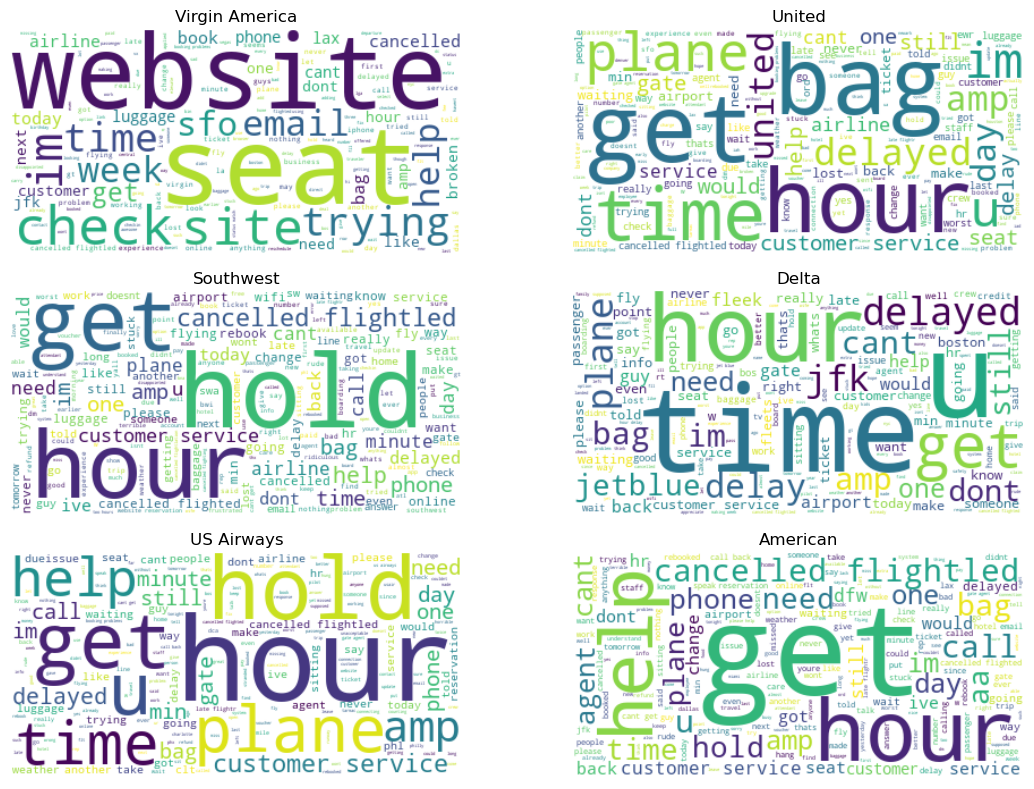

In [18]:
word_cloud(data1,stopwords)

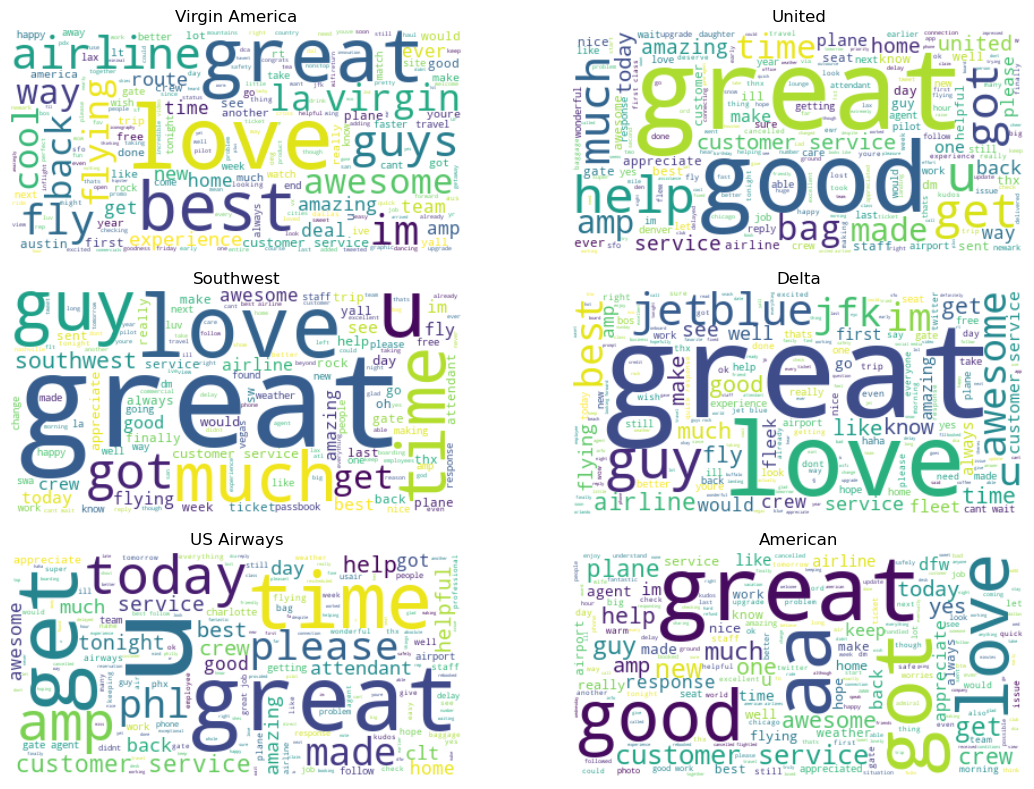

In [19]:
word_cloud(data2,stopwords)

### Distribution of positive/neutral/negative sentiment across all airlines

In [20]:
# Plot to analyze the distribution of sentiments across various entities

def create_subplots(data, dynamic_title):    
    # Create a subplot with 1 row and 2 columns
    fig = make_subplots(rows = 1, cols = 2, subplot_titles = (f'Count of Tweets for {dynamic_title}', f'Distribution of Sentiments Across {dynamic_title}'))

    # Plot the overall distribution of tweets for all the airline
    counter = data.iloc[:, 0].value_counts()
    X = data.iloc[:, 0].value_counts().index.to_list()
    fig.add_trace(go.Bar(x = X, y = counter, showlegend = False, marker_color = 'darkgrey'), row = 1, col = 1)
    fig.update_xaxes(title_text = dynamic_title, row = 1, col = 1)
    fig.update_yaxes(title_text = 'Tweet Count', row = 1, col = 1)

    # Calculate the percentage of each sentiment for each airline
    df = pd.crosstab(data.iloc[:,  0], data.iloc[:,  1], normalize = 'index').reset_index()

    # Create the stacked bar chart
    fig.add_trace(go.Bar(x = df.iloc[:,  0], y = df['negative'], name = 'Negative', texttemplate = '%{y:.1%}', marker_color = 'indianred', textfont = {'size': 10}), row = 1, col = 2)
    fig.add_trace(go.Bar(x = df.iloc[:,  0], y = df['neutral'], name = 'Neutral', texttemplate = '%{y:.1%}', marker_color = 'lightgrey', textfont = {'size': 10}), row = 1, col = 2)
    fig.add_trace(go.Bar(x = df.iloc[:,  0], y = df['positive'], name = 'Positive', texttemplate = '%{y:.1%}', marker_color = 'seagreen', textfont = {'size': 10}), row = 1, col = 2)
    fig.update_layout(barmode = 'stack', title_text = f'Sentiment analysis across {dynamic_title}', title_x = 0.5)
    fig.update_xaxes(title_text = dynamic_title, row = 1, col = 2, categoryorder = 'array', categoryarray = X)
    fig.update_yaxes(title_text = 'Percentage', row = 1, col = 2, tickformat = '.0%', hoverformat = '.1%')

    # Show the plot
    fig.show()


In [21]:
create_subplots(data[['airline','airline_sentiment']],'Airlines')

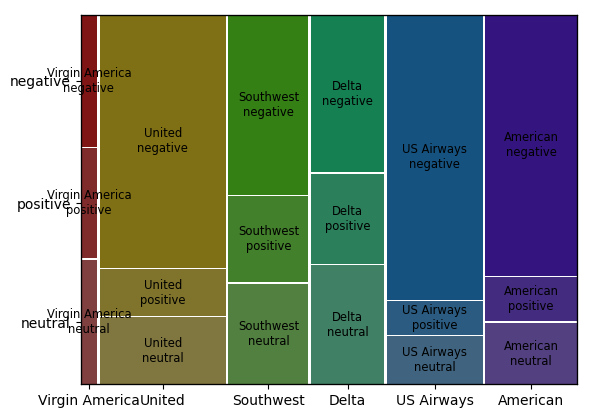

In [22]:
#Another way to visualize the above
from statsmodels.graphics.mosaicplot import mosaic

# Create the mosaic plot
mosaic(data, ['airline', 'airline_sentiment'])

# Show the plot
plt.show()

### Distribution of positive/neutral/negative sentiment across all airlines - make a heatmap

In [23]:
# Create a pivot table with Airline as index and the count of positive tweets as values
positive_pivot = data.pivot_table(index='airline', values='airline_sentiment', aggfunc=lambda x: sum(x == 'positive'))

# Create a pivot table with Airline as index and the count of negative tweets as values
negative_pivot = data.pivot_table(index='airline', values='airline_sentiment', aggfunc=lambda x: sum(x == 'negative'))

# Create a pivot table with Airline as index and the count of neutral tweets as values
neutral_pivot = data.pivot_table(index='airline', values='airline_sentiment', aggfunc=lambda x: sum(x == 'neutral'))

# Compute the overall sentiment score by subtracting the proportion of negative tweets from the proportion of positive tweets
sentiment_score = (positive_pivot - negative_pivot) / (positive_pivot + negative_pivot + neutral_pivot)

# Create a custom hover text that shows the number of positive, negative and neutral tweets for each cell
hover_text = np.empty_like(sentiment_score.values, dtype=object)
for i in range(sentiment_score.shape[0]):
    hover_text[i] = f"Positive: {positive_pivot.iloc[i]}<br>Negative: {negative_pivot.iloc[i]}<br>Neutral: {neutral_pivot.iloc[i]}"

fig = go.Figure(data=go.Heatmap(z=sentiment_score,
                                 x=['Sentiment Score'],
                                 y=sentiment_score.index,
                                 text=hover_text,
                                 hoverinfo="text",
                                 colorscale="RdYlGn",
                                 zmin=-1,
                                 zmax=1))
fig.update_layout(title='Sentiments associated with Airlines',width=800, height=600)

fig.show()

### Classify the emotions in these tweets used a pre trained classifier. I have attached the .pkl files of the pre trained model (for the fit vectorizer and the MNBClassifier)

In [24]:
# Using the fit model and the fit vectorizer from the HW2. To this we have used pickle library from python.
# The library serializes the python object so that it can be deserialized later and used in some other process. 
# This allows us to save the state of an object and later restore it like we are doing here
# First we restore the fit vectorizer

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
    
# Restore the fit classifier model - modelELR from HW2 (Before clustering)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
X = vectorizer.transform(data['text_wc'])

In [26]:
data.loc[:, 'emotion'] = model.predict(X)

data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

                                           text_wc_u  \
0                                          what said   
1  plus youve added commercial to the experience ...   
2  i didnt today must mean i need to take another...   
3  it really aggressive to blast obnoxious entert...   
4             and it a really big bad thing about it   

                                             text_wc  emotion  
0                                          what said  neutral  
1  plus youve added commercials to the experience...  neutral  
2  i didnt today must mean i need to take another...    worry  
3  its really aggressive to blast obnoxious enter...    worry  
4            and its a really big bad thing about it    worry

In [27]:
data['emotion'].unique()

array(['neutral', 'worry', 'sadness', 'happiness', 'love', 'surprise',
       'hate', 'relief'], dtype=object)

In [28]:
# Analyze the correlation between the sentiments and the emotions classified in the previous step

create_subplots(data[['emotion','airline_sentiment']],'Emotions')


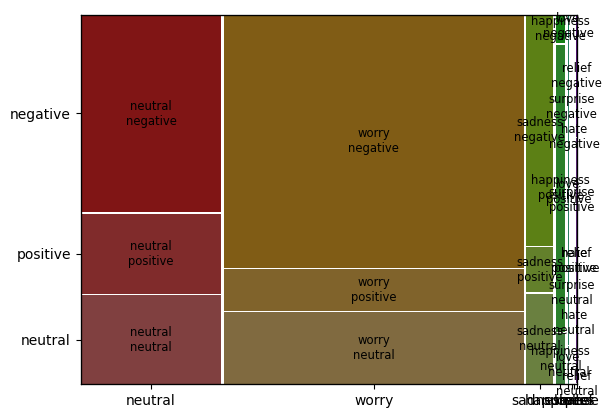

In [29]:
# Create the mosaic plot
mosaic(data, ['emotion', 'airline_sentiment'])

# Show the plot
plt.show()

### Distribution of emotions across different airlines

In [30]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Count of Tweets for Emotions', 'Distribution of Emotions Across Airlines'))

# Plot the overall distribution of tweets for all the airline
counter = data.emotion.value_counts()
X = data.emotion.value_counts().index.to_list()
fig.add_trace(go.Bar(x = X, y = counter, showlegend = False, marker_color = 'darkgrey'), row = 1, col = 1)
fig.update_xaxes(title_text = 'Topics', row = 1, col = 1)
fig.update_yaxes(title_text = 'Tweet Count', row = 1, col = 1)

# Calculate the percentage of each sentiment for each airline
df = pd.crosstab(data.airline, data.emotion, normalize = 'index').reset_index()

# Create the stacked bar chart
for emotion in df.columns[1:]:
    fig.add_trace(go.Bar(x=df.iloc[:, 0], y=df[emotion], name=emotion.capitalize(), texttemplate='%{y:.1%}', textfont={'size': 10}), row=1, col=2)

    
fig.update_layout(barmode='stack', title_text='Topics Analysis across Airlines', title_x=0.5)
fig.update_xaxes(title_text='Airline', row=1, col=2)
fig.update_yaxes(title_text='Percentage', row=1, col=2, tickformat='.0%', hoverformat='.1%')


# Show the plot
fig.show()

### What topics are people talking about in their tweets? How does this distribution of topics differ across airlines?

In [31]:
data_topics = data['text_wc'].values.tolist()

In [35]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [37]:
data_words = list(sent_to_words(data_topics))

print(data_words[:3])

[['what', 'said'], ['plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky'], ['didnt', 'today', 'must', 'mean', 'need', 'to', 'take', 'another', 'trip']]


In [38]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']


In [41]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [44]:
# Build LDA model as per the optimal hyperparameters chosen based on their coherence score. Refer the Appendix section at the end of the file for more details.
# We have modified the num_topics to get the most out of the topics, in a way that there is a proper distinction between them with minimal overlap
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5,
                     random_state=100,
                     chunksize=100,
                     passes=10,
                     alpha='asymmetric',
                     eta=0.61)

In [45]:
# Print the Keywords in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"flight" + 0.040*"get" + 0.032*"call" + 0.026*"hour" + 0.024*"help" + '
  '0.017*"need" + 0.017*"wait" + 0.016*"hold" + 0.014*"phone" + 0.014*"try"'),
 (1,
  '0.097*"flight" + 0.065*"cancel" + 0.033*"thank" + 0.033*"flightle" + '
  '0.026*"tomorrow" + 0.022*"day" + 0.019*"s" + 0.018*"bad" + 0.018*"take" + '
  '0.018*"get"'),
 (2,
  '0.063*"customer" + 0.058*"service" + 0.035*"tell" + 0.026*"know" + '
  '0.019*"let" + 0.019*"email" + 0.019*"passenger" + 0.015*"never" + '
  '0.014*"staff" + 0.010*"rude"'),
 (3,
  '0.059*"delay" + 0.039*"guy" + 0.038*"say" + 0.024*"give" + 0.020*"re" + '
  '0.015*"stick" + 0.013*"hotel" + 0.012*"busy" + 0.011*"arrive" + '
  '0.011*"voucher"'),
 (4,
  '0.050*"agent" + 0.025*"luggage" + 0.024*"line" + 0.023*"people" + '
  '0.022*"see" + 0.020*"issue" + 0.020*"send" + 0.016*"long" + 0.015*"look" + '
  '0.014*"understand"')]


In [46]:
pyLDAvis.enable_notebook()
vis = plt_gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.260638 -0.159158       1        1  44.159049
1      0.174240  0.207867       2        1  23.120742
2     -0.132429 -0.136368       3        1  12.880178
3     -0.143701  0.074453       4        1  10.105793
4     -0.158748  0.013206       5        1   9.734238, topic_info=         Term         Freq        Total Category  logprob  loglift
23     flight  4604.000000  4604.000000  Default  30.0000  30.0000
277    cancel  1550.000000  1550.000000  Default  29.0000  29.0000
242  customer   832.000000   832.000000  Default  28.0000  28.0000
157   service   769.000000   769.000000  Default  27.0000  27.0000
275     delay   610.000000   610.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
353   helpful    77.985585    81.773095   Topic5  -4.8501   2.2821
323    direct    57.231379    60.038817   Topic5  -5.1596   2.2816
481   apology    64.984943    68.454858   Topic5  -5.0325   2.2775
441     happy    60.888733    64.031199   Topic5  -5.0976   2.2792
112  response    69.662772   231.116810   Topic5  -4.9630   1.1303

[214 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1774      1  0.979357     aa
1774      2  0.011257     aa
1774      3  0.005628     aa
1774      4  0.002814     aa
1774      5  0.002814     aa
...     ...       ...    ...
311       5  0.002627   work
124       1  0.013920  worry
124       2  0.013920  worry
124       3  0.013920  worry
124       4  0.974429  worry

[875 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [47]:
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]

In [48]:
best_topics = [max(lda_model.get_document_topics(corpus[i]), key=lambda x: x[1])[0] for i in range(len(corpus))]

# Add the identified topics to the tweets
data['best_topic'] = best_topics

In [49]:
# Identify Topic labels based on the words identified in each topic and then load it into the original dataframe
topic_labels = {0: 'Customer Service', 1: 'Flight Cancellations', 2: 'Customer Complaints', 
               3: 'Flight Delays', 4: 'Baggage Issues'}
data['best_topic_label'] = data['best_topic'].map(topic_labels)

In [50]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Count of Tweets for Topics', 'Distribution of Topics Across Airlines'))

# Plot the overall distribution of tweets for all the airline
counter = data.best_topic_label.value_counts()
X = data.best_topic_label.value_counts().index.to_list()
fig.add_trace(go.Bar(x = X, y = counter, showlegend = False, marker_color = 'darkgrey'), row = 1, col = 1)
fig.update_xaxes(title_text = 'Topics', row = 1, col = 1)
fig.update_yaxes(title_text = 'Tweet Count', row = 1, col = 1)

# Calculate the percentage of each sentiment for each airline
df = pd.crosstab(data.airline, data.best_topic_label, normalize = 'index').reset_index()

# Create the stacked bar chart
for emotion in df.columns[1:]:
    fig.add_trace(go.Bar(x=df.iloc[:, 0], y=df[emotion], name=emotion.capitalize(), texttemplate='%{y:.1%}', textfont={'size': 10}), row=1, col=2)

    
fig.update_layout(barmode='stack', title_text='Topics Analysis across Airlines', title_x=0.5)
fig.update_xaxes(title_text='Airline', row=1, col=2)
fig.update_yaxes(title_text='Percentage', row=1, col=2, tickformat='.0%', hoverformat='.1%')


# Show the plot
fig.show()

### Heat map that shows the sentiment associated with the airlines for different topics

In [51]:
# Create a pivot table with Airline and Topic as indices and the count of positive tweets as values
positive_pivot = data.pivot_table(index='airline', columns='best_topic_label', values='airline_sentiment', aggfunc=lambda x: sum(x == 'positive'))

# Create a pivot table with Airline and Topic as indices and the count of negative tweets as values
negative_pivot = data.pivot_table(index='airline', columns='best_topic_label', values='airline_sentiment', aggfunc=lambda x: sum(x == 'negative'))

# Create a pivot table with Airline and Topic as indices and the count of neutral tweets as values
neutral_pivot = data.pivot_table(index='airline', columns='best_topic_label', values='airline_sentiment', aggfunc=lambda x: sum(x == 'neutral'))

# Compute the overall sentiment score by subtracting the proportion of negative tweets from the proportion of positive tweets
sentiment_score = (positive_pivot - negative_pivot) / (positive_pivot + negative_pivot + neutral_pivot)

# Create a custom hover text that shows the number of positive, negative and neutral tweets for each cell
hover_text = np.empty_like(sentiment_score.values, dtype=object)
for i in range(sentiment_score.shape[0]):
    for j in range(sentiment_score.shape[1]):
        hover_text[i,j] = f"Positive: {positive_pivot.iloc[i,j]}<br>Negative: {negative_pivot.iloc[i,j]}<br>Neutral: {neutral_pivot.iloc[i,j]}"

fig = go.Figure(data=go.Heatmap(z=sentiment_score,
                                 x=sentiment_score.columns,
                                 y=sentiment_score.index,
                                 text=hover_text,
                                 hoverinfo="text",
                                 colorscale="RdYlGn",
                                 zmin=-1,
                                 zmax=1))
fig.update_layout(title='Sentiments associated with Airlines for Different Topics',width=800, height=600)

fig.show()

### United: For every topic, what are the emotions attached with the topic?

In [57]:
# Create a subplot with 1 row and 2 columns

data1 = data[data['airline'] == 'United']

fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Count of Tweets for Topics', 'Distribution of Topics Across Airlines'))

# Plot the overall distribution of tweets for all the airline
counter = data.best_topic_label.value_counts()
X = data.best_topic_label.value_counts().index.to_list()
fig.add_trace(go.Bar(x = X, y = counter, showlegend = False, marker_color = 'darkgrey'), row = 1, col = 1)
fig.update_xaxes(title_text = 'Topics', row = 1, col = 1)
fig.update_yaxes(title_text = 'Tweet Count', row = 1, col = 1)

# Calculate the percentage of each sentiment for each airline
df = pd.crosstab(data1.best_topic_label, data1.emotion, normalize = 'index').reset_index()

# Create the stacked bar chart
for emotion in df.columns[1:]:
    fig.add_trace(go.Bar(x=df.iloc[:, 0], y=df[emotion], name=emotion.capitalize(), texttemplate='%{y:.1%}', textfont={'size': 10}), row=1, col=2)

    
fig.update_layout(barmode='stack', title_text='Topics Analysis across Airlines', title_x=0.5)
fig.update_xaxes(title_text='Airline', row=1, col=2, categoryorder = 'array', categoryarray = X)
fig.update_yaxes(title_text='Percentage', row=1, col=2, tickformat='.0%', hoverformat='.1%')


# Show the plot
fig.show()

### Southwest and United. Show how these airlines differ based on the emotions consumers express about them in the tweets.

In [53]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Count of Tweets for Emotions', 'Distribution of Emotions Across Airlines'))

# Plot the overall distribution of tweets for all the airline
counter = data[(data['airline'] == 'Southwest') | (data['airline'] == 'United')].emotion.value_counts()
X = data.emotion.value_counts().index.to_list()
fig.add_trace(go.Bar(x=X, y=counter, showlegend=False, marker_color='darkgrey'), row=1, col=1)
fig.update_xaxes(title_text='Emotions', row=1, col=1)
fig.update_yaxes(title_text='Tweet Count', row=1, col=1)

# Calculate the percentage of each sentiment for each airline
df = pd.crosstab(data['airline'], data['emotion'], normalize='index').reset_index()

df = df[(df['airline'] == 'Southwest') | (df['airline'] == 'United')]

# Create the stacked bar chart
for emotion in df.columns[1:]:
    fig.add_trace(go.Bar(x=df.iloc[:, 0], y=df[emotion], name=emotion.capitalize(), texttemplate='%{y:.1%}', textfont={'size': 10}), row=1, col=2)

fig.update_layout(barmode='stack', title_text='Emotions Analysis for Southwest and United Airlines', title_x=0.5)
fig.update_xaxes(title_text='Airline', row=1, col=2, tickangle=45)
fig.update_yaxes(title_text='Percentage', row=1, col=2, tickformat='.0%', hoverformat='.1%')

# Show the plot
fig.show()

### Perception map between 2 topics across airlines

In [55]:
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
data['airline_sentiment'] = data['airline_sentiment'].map(sentiment_mapping)


In [58]:
# Choose two topics for the x and y axes
x_topic = 'Customer Service'
y_topic = 'Flight Cancellations'


# Filter the data to only include rows with the specified topics
filtered_data = data[data['best_topic_label'].isin([x_topic, y_topic])]

# Group the filtered data by airline and topic and calculate the mean sentiment for each group
grouped_data = filtered_data.groupby(['airline', 'best_topic_label'])['airline_sentiment'].mean()

# Unstack the grouped data to create a DataFrame with one row for each airline and one column for each topic
unstacked_data = grouped_data.unstack()

# Plot the perception map using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=unstacked_data[x_topic], y=unstacked_data[y_topic], mode='markers+text', text=unstacked_data.index, textposition='top center'))
fig.update_layout(xaxis_range=[-1, 1], yaxis_range=[-1, 1], title='Perception map for Airlines',width=800, height=600, title_x=0.5
                 ,xaxis_title=x_topic, yaxis_title=y_topic)
fig.show()


### Perception map to visualize the maximum separation between airlines based on the available topics. The reason of doing this is to understand the relative max difference between airlines across topics

In [59]:
import plotly.graph_objs as go
import numpy as np

x_topic = ['Customer Service','Flight Cancellations', 'Customer Complaints', 'Flight Delays', 'Baggage Issues']
y_topic = ['Customer Service','Flight Cancellations', 'Customer Complaints', 'Flight Delays', 'Baggage Issues']

max_spread = 0
best_fig = None
best_x = None
best_y = None

for x in x_topic:
    for y in y_topic:
        if x == y:
            continue
        filtered_data = data[data['best_topic_label'].isin([x, y])]
        grouped_data = filtered_data.groupby(['airline', 'best_topic_label'])['airline_sentiment'].mean()
        unstacked_data = grouped_data.unstack()
        spread = np.ptp(unstacked_data[x]) + np.ptp(unstacked_data[y])
        if spread > max_spread:
            max_spread = spread
            best_x = x
            best_y = y
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=unstacked_data[x], y=unstacked_data[y], mode='markers+text', text=unstacked_data.index, textposition='top center'))
            fig.update_layout(xaxis_range=[-1, 1], yaxis_range=[-1, 1], title='Perception map for Airlines',width=800, height=600, title_x=0.5
                             ,xaxis_title=x, yaxis_title=y)
            best_fig = fig

best_fig.show()

## Appendix

We have used to below to identify the ideal combination of parameters while identifying the topics in the corpus. The code snippet takes a lot of time to run hence converted into a markdown cells beyond this time.

# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()